In [ ]:
# default_exp plots

In [ ]:
#export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
#export
def plot_shapley(x, fc, ref, shapley_values, n_attributes):
    
    # Get output for x and ref 
    pred_x = fc(x.values)
    # Individual reference or dataset of references 
    if isinstance(ref, pd.core.series.Series):
        pred_ref = fc(ref.values)
    elif isinstance(ref, pd.core.frame.DataFrame):
        if ref.shape[0] == 1:
            ref = ref.iloc[0]
            pred_ref = fc(ref.values)
        else:
            rewards = []
            for idx in range(len(ref)):
                rewards.append(fc(ref.values[idx,:]))
            pred_ref = np.mean(rewards)

    # Create a series for plotting
    x_attributes = [feature + " = " + str(val) if isinstance(val, str) else feature + " = " + str(round(val,2)) for feature, val in x.iteritems()]
    s_plot = pd.Series(data=shapley_values.values, index=x_attributes)
    attributes = s_plot.abs().sort_values(ascending=False)[:n_attributes].index
    s_plot = s_plot[attributes]
    
    # Plot 
    fig = plt.figure(figsize=(12,7))
    plt.ylim(ymin=0, ymax=len(attributes) + 1)
    
    # Cumulative horizontal arrows for Shapley values ordered by absolute values
#     s_plot_sorted = s_plot.sort_values(ascending=False)
    attribute_order = s_plot.abs().sort_values(ascending=False).index
    s_plot_sorted = s_plot[attribute_order]
    epsilon = 1e-5 # avoid arrows with width=0.
    past_val = 0.
    for idx, (attr, val) in enumerate(s_plot_sorted.iteritems()):
        if val >= 0:
            arrow = mpatches.FancyArrow(x=past_val, y=idx+1, dx=val+epsilon, dy=0, width=0.8, length_includes_head=True, head_width=0.8,
                                head_length=(val+epsilon)/10, shape='full', overhang=0, head_starts_at_zero=False, color="cornflowerblue")
            fig.get_axes()[0].add_patch(arrow)
            plt.text(x=past_val + val/2, y=idx+1, s="+"+str(round(val,2)), fontsize=20)
        else:
            arrow = mpatches.FancyArrow(x=past_val, y=idx+1, dx=val-epsilon, dy=0, width=0.8, length_includes_head=True, head_width=0.8,
                                head_length=-(val-epsilon)/10, shape='full', overhang=0, head_starts_at_zero=False, color="lightsalmon")
            fig.get_axes()[0].add_patch(arrow)
            plt.text(x=past_val + val/2, y=idx+1, s="-"+str(round(np.abs(val),2)), fontsize=20)
        if idx > 0:
            plt.vlines(past_val, ymin=idx, ymax=idx+1, colors="k", linewidth=1, linestyles="--")
        past_val += val
        
    # Rearrange yticks and its labels
    fig.get_axes()[0].set_yticks(range(1, len(attributes)+1))
    fig.get_axes()[0].set_yticklabels(list(s_plot_sorted.index))
    
    # Display vertical arrows for reference and x outputs
    width_ = np.abs(pred_x - pred_ref) / 100
    arrow = mpatches.FancyArrow(0, 0, 0, 1, width=width_, length_includes_head=True, head_width=width_,
                                head_length=0.2, shape='full', overhang=0, head_starts_at_zero=False,
                                color="forestgreen", label="reference output = "+str(round(pred_ref,2)))
    fig.get_axes()[0].add_patch(arrow)
    arrow = mpatches.FancyArrow(pred_x - pred_ref, idx+1, 0, 1, width=width_, length_includes_head=True, head_width=width_,
                                head_length=0.2, shape='full', overhang=0, head_starts_at_zero=False,
                                color="midnightblue", label="x output = "+str(round(pred_x,2)))
    fig.get_axes()[0].add_patch(arrow)
    
    # Rename xticks labels because zero is the reference reward
    xticks_label = np.round(fig.get_axes()[0].get_xticks() + pred_ref, 2)
    fig.get_axes()[0].set_xticklabels(xticks_label)
    
    plt.legend(loc='best')
    plt.xlabel("Output")
    plt.ylabel("x attributes")
    plt.show()

## Example

We use a simulated dataset from the book _Elements of Statistical Learning_ ([hastie,2009], the Radial example). $X_1, \dots , X_{d}$ are standard independent Gaussian. The model is determined by:

$$ Y = \prod_{j=1}^{d} \rho(X_j), $$

where $\rho\text{: } t \rightarrow \sqrt{(0.5 \pi)} \exp(- t^2 /2)$. The regression function $f_{regr}$ is deterministic and simply defined by $f_r\text{: } \textbf{x} \rightarrow \prod_{j=1}^{d} \phi(x_j)$. For a reference $\mathbf{r^*}$ and a target $\mathbf{x^*}$, we define the reward function $v_r^{\mathbf{r^*}, \mathbf{x^*}}$ such as for each coalition $S$, $v_r^{\mathbf{r^*}, \mathbf{x^*}}(S) = f_{regr}(\mathbf{z}(\mathbf{x^*}, \mathbf{r^*}, S)) - f_{regr}(\mathbf{r^*}).$

 [hastie,2009] _The Elements of Statistical Learning: Data Mining, Inference, and Prediction, Second Edition_. Hastie, Trevor and Tibshirani, Robert and Friedman, Jerome. Springer Series in Statistics, 2009.
	

In [ ]:
d, n_samples = 5, 100
mu = np.zeros(d)
Sigma = np.zeros((d,d))
np.fill_diagonal(Sigma, [1] * d)
X = np.random.multivariate_normal(mean=mu, cov=Sigma, size=n_samples)
X = pd.DataFrame(X, columns=['x'+str(i) for i in range(1, d+1)])
def fc(x):
    phi_x = np.sqrt(.5 * np.pi) * np.exp(-0.5 * x ** 2)
    return np.prod(phi_x)
y = np.zeros(len(X))
for i in range(len(X)):
    y[i] = fc(X.values[i])
n = 2**d - 2
print("dimension = {0} ; nb of coalitions = {1}".format(str(d), str(n)))

dimension = 5 ; nb of coalitions = 30


In [ ]:
from shapkit_nbdev.shapley_values import ShapleyValues

### Pick an individual x to explain

In [ ]:
x = X.iloc[np.random.choice(len(X), size=1)[0],:]
x

x1   -0.464408
x2    0.018879
x3    2.008941
x4   -0.899668
x5    1.157927
Name: 27, dtype: float64

### Single reference

In [ ]:
reference = X.iloc[np.random.choice(len(X), size=1)[0],:]
reference

x1   -1.005158
x2   -0.336999
x3   -1.810419
x4   -0.839191
x5    0.796232
Name: 42, dtype: float64

In [ ]:
true_shap = ShapleyValues(x=x, fc=fc, ref=reference)

100%|██████████| 5/5 [00:00<00:00, 268.20it/s]


In [ ]:
true_shap

x1    0.062138
x2    0.008773
x3   -0.058060
x4   -0.008125
x5   -0.054161
dtype: float64

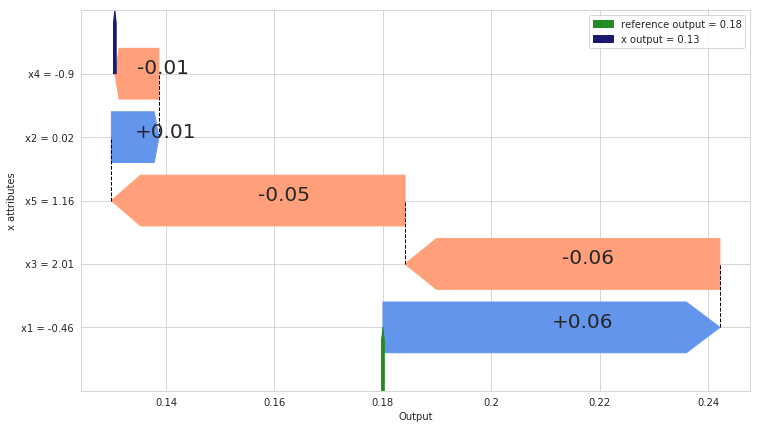

In [ ]:
plot_shapley(x=x, fc=fc, ref=reference, shapley_values=true_shap, n_attributes=5)

### Several references 

In [ ]:
references = X.iloc[np.random.choice(len(X), size=10, replace=False),:]
references

,x1,x2,x3,x4,x5
54,1.213967,0.931206,-0.524708,-0.753055,-0.923654
32,-0.886220,-1.258168,-0.987226,0.822218,0.336016
96,-0.880033,-1.572747,-0.903674,-0.395526,0.135087
19,0.672377,1.301552,0.675478,0.312630,0.935312
55,-0.406830,-0.132195,-0.965188,-0.414374,1.136633
71,0.229544,-1.260001,0.196788,0.326800,-0.415964
36,-0.710906,-1.414816,1.642201,1.133323,0.443849
21,-0.015290,-1.714221,-0.135158,-0.942600,-0.396114
59,0.660268,0.332635,-0.784808,0.854871,-0.552012
50,1.570867,-1.106862,-0.179201,0.114782,-0.284406


In [ ]:
true_shaps = ShapleyValues(x=x, fc=fc, ref=references, K=len(references))

100%|██████████| 5/5 [00:00<00:00, 37.56it/s]


In [ ]:
true_shaps

x1    0.092146
x2    0.285799
x3   -0.570836
x4   -0.079161
x5   -0.174111
dtype: float64

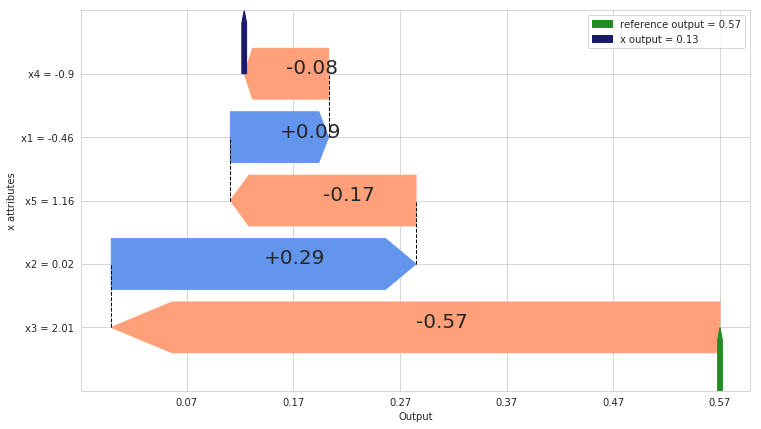

In [ ]:
plot_shapley(x=x, fc=fc, ref=references, shapley_values=true_shaps, n_attributes=6)

## Export-

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted index.ipynb.
Converted inspector.ipynb.
Converted monte_carlo_shapley.ipynb.
Converted plots.ipynb.
Converted sgd_shapley.ipynb.
Converted shapley_values.ipynb.
